# Research Question

We'll be using a Neural Network model and Natural Language Processing to perform sentinment analysis on reviews. Our goal is to build a model that can predict if a sentence is positive or negative.

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Data Preparation

The raw data must be modified from it's raw form in order to be used in out Neural Network.

## Import Data

We are using three differet data source files, each contains 500 sentences labeled positive or negative. The sentances are sourced from Amazon reviews, IMDB reviews, and Yelp reviews. 

We import each file in its ``.txt`` form and convert them into dataframes.

In [2]:
with open('data/amazon_cells_labelled.txt') as f:
    reader = csv.reader(f, delimiter='\t')
    amazon = list(reader)

amazon_df = pd.DataFrame(amazon, columns=['sentence', 'label'])
amazon_df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [3]:
with open('data/imdb_labelled.txt') as f:
    reader = csv.reader(f, delimiter='\t')
    imdb = list(reader)
    
imdb_df = pd.DataFrame(imdb, columns=['sentence', 'label'])
imdb_df.head()

,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
with open('data/yelp_labelled.txt') as f:
    reader = csv.reader(f, delimiter='\t')
    yelp = list(reader)

yelp_df = pd.DataFrame(yelp, columns=['sentence', 'label'])
yelp_df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Now we concat the three dataframes into a single one.

In [5]:
df = pd.concat([amazon_df, imdb_df, yelp_df])

# df = amazon_df
df['label'] = df['label'].astype(int)
df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


## Exploratory Data Analysis

We want to explore the dataset more before we built our model. In particular, we want to know more about the length and word count of our sentences.

In [6]:
# count characters and words
df['chars'] = df['sentence'].apply(len)
df['words'] = df['sentence'].apply(lambda x: len(x.split()))
df.head()

,sentence,label,chars,words
0,So there is no way for me to plug it in here i...,0,82,21
1,"Good case, Excellent value.",1,27,4
2,Great for the jawbone.,1,22,4
3,Tied to charger for conversations lasting more...,0,79,11
4,The mic is great.,1,17,4


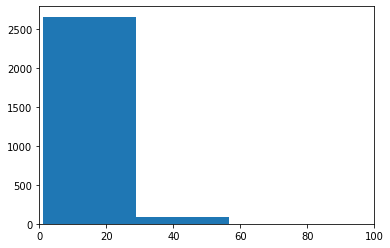

Average words:  13.006550218340612
Max words:  1390
Min words:  1


In [7]:
# plot histogram
plt.hist(df['words'], bins=50)
plt.xlim(0, 100)
plt.show()

# print summary statistics
avg_words = np.mean(df['words'])
print('Average words: ', avg_words)
print('Max words: ', np.max(df['words']))
print('Min words: ', np.min(df['words']))

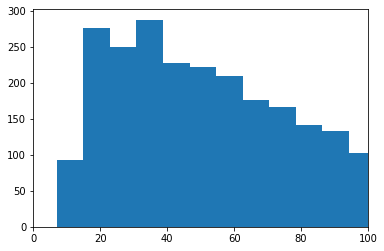

Average chars:  71.52838427947599
Max chars:  7944
Min chars:  7


In [8]:
plt.clf()
# plot histogram
plt.hist(df['chars'], bins=1000)
plt.xlim(0, 100)
plt.show()

# print summary statistics
avg_chars = np.mean(df['chars'])
print('Average chars: ', avg_chars)
print('Max chars: ', np.max(df['chars']))
print('Min chars: ', np.min(df['chars']))

## Preprocessing

We'll define a preprocessing function that makes use of tensorflow's preprocessing capabilities to:
- truncate sentences to a specified length. We'll be using the average character length. This should be statistically large enough to convey the sentiment of the sentence.
- replace charaters other than letters and quotes with spaces. This will remove characters such as emojis
- pad the sentences

Preprocessing function based on code from *Hands-On Machine Learning with SciKit-Learn, Keras, & Tensorflow*[1].

In [9]:
# chapter 16, page 536
def preprocess(X_batch, y_batch):
    # truncate sentences to only contain the average number of characters
    X_batch = tf.strings.substr(X_batch, 0, avg_chars)
    # replaces any characters other than letters and quotes with spaces
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    # splits by spaces
    X_batch = tf.strings.split(X_batch)
    # pad
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

X, y = preprocess(df['sentence'], df['label'])
# show a processed sentence
print(X.numpy()[1])

[b'Good' b'case' b'Excellent' b'value' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>']


## Vocabulary

We'll count the total number of unique words in the data.

In [10]:
from collections import Counter
vocabulary = Counter()
for text in X:
    vocabulary.update(list(text.numpy()))

print(vocabulary.most_common(5))
print('Total unique words: ', len(vocabulary))

[(b'<pad>', 29008), (b'the', 1000), (b'and', 783), (b'I', 744), (b'a', 623)]
Total unique words:  4855


Now we'll truncate the vocabulary to half it's original size, taking only the top 50% recurring words.

In [11]:
vocab_size = int(len(vocabulary) / 2)
truncated_vocab = [w for w, c in vocabulary.most_common()[:vocab_size]]
print('New Vocab Size: ', len(truncated_vocab))

New Vocab Size:  2427


We create a lookuptable for the new vocabulary.

In [12]:
words = tf.constant(truncated_vocab)
word_ids = tf.range(len(truncated_vocab), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

## Train/Test split

In [13]:
def encode_words(X_batch, y_batch):
    # use our existing preprocess function to get the tensors
    X_, y_ = preprocess(X_batch, y_batch)
    # convert the tensors to word ids
    return table.lookup(X_), y_

# split the raw dataframe into train and test
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['label'], test_size=0.2, random_state=69)
# use our encode_words function to get encoded words
X_train, y_train = encode_words(X_train, y_train)
X_test, y_test = encode_words(X_test, y_test)

# Model

Now it is time to build and fit the model. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 11)          37697     
                                                                 
 gru (GRU)                   (None, None, 20)          1980      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 42,218
Trainable params: 42,218
Non-trainable params: 0
_________________________________________________________________


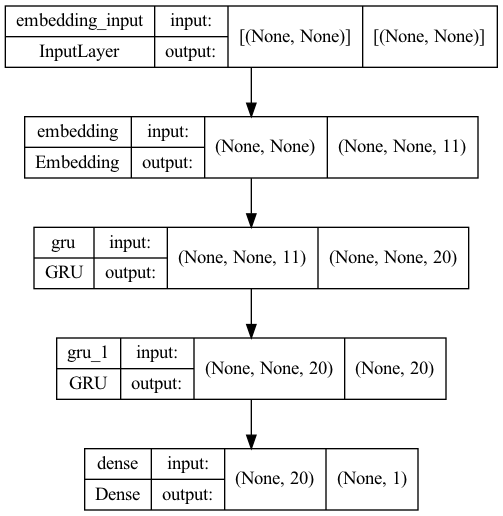

In [14]:
embed_size = 11
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Our architecture is as follows:

- Embedding Layer which will convert word IDs into embeddings
- 2 Gated Recurrent Unit (GRU) layer, of which the last one only returns the output of the last time step
- Single output neuron using the Sigmoid activation function. This will be a number representing the probability of the sentence expressing a positive sentiment.
- Loss Function: BinaryCrossentropy since this is a binary classification problem 
- Optimizor: Adaptive Moment Estimation (ADAM). It is "The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters" [1]


We'll be running the model for 8 epochs.

In [15]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_test, y_test), batch_size=16)

Epoch 1/8


2022-04-08 15:04:20.272989: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


138/138 [==============================] - 5s 15ms/step - loss: 0.6820 - accuracy: 0.5491 - val_loss: 0.6115 - val_accuracy: 0.6655
Epoch 2/8
138/138 [==============================] - 1s 7ms/step - loss: 0.4026 - accuracy: 0.8308 - val_loss: 0.4603 - val_accuracy: 0.7891
Epoch 3/8
138/138 [==============================] - 1s 8ms/step - loss: 0.1842 - accuracy: 0.9359 - val_loss: 0.5341 - val_accuracy: 0.7964
Epoch 4/8
138/138 [==============================] - 1s 8ms/step - loss: 0.0915 - accuracy: 0.9713 - val_loss: 0.6529 - val_accuracy: 0.7764
Epoch 5/8
138/138 [==============================] - 1s 7ms/step - loss: 0.0439 - accuracy: 0.9886 - val_loss: 0.8218 - val_accuracy: 0.7727
Epoch 6/8
138/138 [==============================] - 1s 8ms/step - loss: 0.0270 - accuracy: 0.9936 - val_loss: 0.9883 - val_accuracy: 0.7909
Epoch 7/8
138/138 [==============================] - 1s 8ms/step - loss: 0.0184 - accuracy: 0.9959 - val_loss: 0.9976 - val_accuracy: 0.7709
Epoch 8/8
138/138 [===

## Accuracy

Final Training Accuracy: 0.9982
Final Validation Accuracy:  0.7764


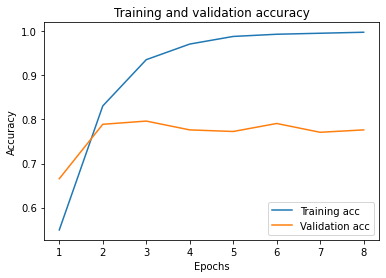

In [16]:
history_dict = history.history

acc = history_dict['accuracy']
print("Final Training Accuracy: {:.4f}".format(acc[-1]))

val_acc = history_dict['val_accuracy']
print("Final Validation Accuracy:  {:.4f}".format(val_acc[-1]))

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We see our validation accuracy begin to stagnate around 3 epochs in the high 70s while our training data continues to trend towards 100%. This suggests some mild overfitting. However, even with the overfitting our model is still almost 80% accurate.

# Summary and Recommendations

We've created a reasonably accurate model to predict positive sentiment across multiple review contexts. This model could be deployed by a company to quickly analyze what consumers think about a particular product.

# Bibliography

[1] Geron, Aurelien. *Hands-On Machine Learning with Scikit-Learn, Keras, & Tensorflow*. Kiwisoft S.A.S, 2020.
[2] Kingma, Ba. "Adam: A Method for Stochastic Optimization". *Cornell University*, 8 April 2022, https://arxiv.org/abs/1412.6980
